In [ ]:
#!gdown 1-71hYGVEWoJH3JTtH9CAsSQ6PotpiZBW

In [ ]:
import os
import cv2
import shutil
import secrets
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Sequential, Model
from keras import optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from PIL import ImageFile
import seaborn as sns
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as pre_in2
# from tensorflow.keras.applications.alexnet import AlexNet, preprocess_input

In [ ]:
PARENT_PATH = os.getcwd()
DATA_PATH = os.path.join(os.getcwd(),"CombinedNew", "Combined New")
TEST_PATH = os.path.join(DATA_PATH, "test")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
NEW_TRAIN_PATH = os.path.join(DATA_PATH, "new_train")
VALID_PATH = os.path.join(DATA_PATH, "valid")
UNSEEN_PATH = os.path.join(DATA_PATH, "unseen")
MODEL_PATH = "drive/MyDrive/models"
NUM_CLASSES = 8

In [ ]:
if os.path.exists(DATA_PATH):
  shutil.rmtree(DATA_PATH)
from zipfile import ZipFile
password = "57Rk!F8yUz38"
with ZipFile('drive/MyDrive/CombinedNew.zip') as zipObj:
  zipObj.extractall()

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
NUM_EPOCH = 30

In [ ]:
# PREP_DATA_PATH = os.path.join(os.getcwd(),"Distracted Driver Dataset","Camera 1 - Prep")
# if os.path.exists(PREP_DATA_PATH):
#   shutil.rmtree(PREP_DATA_PATH)
# shutil.copytree(DATA_PATH, PREP_DATA_PATH)

In [ ]:
for class_folder in os.listdir(TRAIN_PATH):
  class_path = os.path.join(TRAIN_PATH, class_folder)
  if class_folder == ".DS_Store":
      continue
  train_imgs, test_imgs = train_test_split(os.listdir(class_path), test_size=0.2, random_state = 42)

  for img in train_imgs: 
    src = os.path.join(class_path, img)
    dst = os.path.join(NEW_TRAIN_PATH, class_folder, img)
    if not os.path.exists(os.path.join(NEW_TRAIN_PATH, class_folder)):
      os.makedirs(os.path.join(NEW_TRAIN_PATH, class_folder))
    shutil.copy(src, dst)

  for img in test_imgs: 
    src = os.path.join(class_path, img)
    dst = os.path.join(VALID_PATH, class_folder, img)
    if not os.path.exists(os.path.join(VALID_PATH, class_folder)):
      os.makedirs(os.path.join(VALID_PATH, class_folder))
    shutil.copy(src, dst)

In [ ]:
def create_df(DATA_PATH):
  cls_names = os.listdir(DATA_PATH)
  data = []
  for cls in cls_names: 
    if cls == ".DS_Store":
      continue
    cls_path = os.path.join(DATA_PATH, cls)
    print(cls_path)
    for file in os.listdir(cls_path):
      data.append({"Filename": os.path.join(cls, file), "Class": cls})
  df = pd.DataFrame(data)
  return df
  
train_df = create_df(NEW_TRAIN_PATH)
valid_df = create_df(VALID_PATH)
test_df = create_df(TEST_PATH)

/content/CombinedNew/Combined New/new_train/c6
/content/CombinedNew/Combined New/new_train/c2
/content/CombinedNew/Combined New/new_train/c5
/content/CombinedNew/Combined New/new_train/c3
/content/CombinedNew/Combined New/new_train/c1
/content/CombinedNew/Combined New/new_train/c7
/content/CombinedNew/Combined New/new_train/c0
/content/CombinedNew/Combined New/new_train/c4
/content/CombinedNew/Combined New/valid/c6
/content/CombinedNew/Combined New/valid/c2
/content/CombinedNew/Combined New/valid/c5
/content/CombinedNew/Combined New/valid/c3
/content/CombinedNew/Combined New/valid/c1
/content/CombinedNew/Combined New/valid/c7
/content/CombinedNew/Combined New/valid/c0
/content/CombinedNew/Combined New/valid/c4
/content/CombinedNew/Combined New/test/c6
/content/CombinedNew/Combined New/test/c2
/content/CombinedNew/Combined New/test/c5
/content/CombinedNew/Combined New/test/c3
/content/CombinedNew/Combined New/test/c1
/content/CombinedNew/Combined New/test/c7
/content/CombinedNew/Combine

<Axes: >

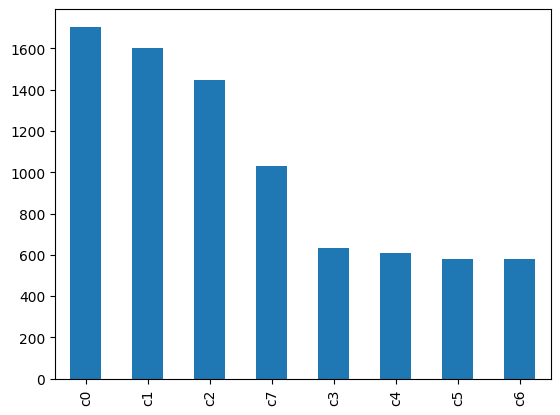

In [ ]:
train_df['Class'].value_counts().plot.bar()

<Axes: >

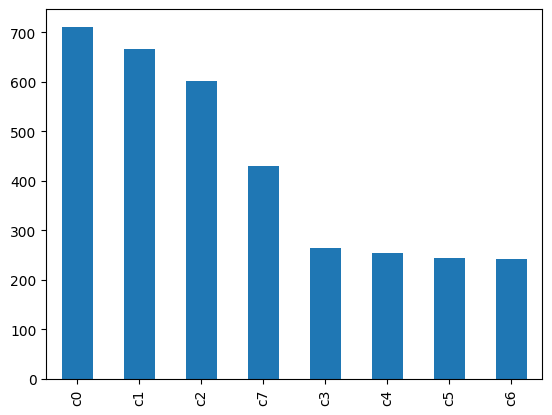

In [ ]:
test_df['Class'].value_counts().plot.bar()

In [ ]:
rotation_range = 5
width_shift_range = 0.01
height_shift_range = 0.01
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
verticle_flip = False
fill_mode = "nearest"

In [ ]:
# for inc
train_datagen = ImageDataGenerator(
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        zoom_range = zoom_range,
        fill_mode = fill_mode,
        validation_split = 0.2,
        preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(
        validation_split = 0.2,
        preprocessing_function = preprocess_input
)

train_data = train_datagen.flow_from_directory(NEW_TRAIN_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

valid_data = test_datagen.flow_from_directory(VALID_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)
test_data = test_datagen.flow_from_directory(TEST_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
unseen_data = test_datagen.flow_from_directory(UNSEEN_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

Found 8176 images belonging to 8 classes.
Found 2049 images belonging to 8 classes.
Found 3414 images belonging to 8 classes.
Found 839 images belonging to 8 classes.


In [ ]:
classes = [i for i in range(8)]
print(classes)

[0, 1, 2, 3, 4, 5, 6, 7]


In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_data.classes)
class_weights = dict(enumerate(class_weights.flatten(), 0))
print(class_weights)

{0: 0.5997652582159625, 1: 0.63875, 2: 0.7077562326869806, 3: 1.6170886075949367, 4: 1.6781609195402298, 5: 1.7620689655172415, 6: 1.768166089965398, 7: 0.9931972789115646}


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16_fine_tuned = Sequential()
vgg16_fine_tuned.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
vgg16_fine_tuned.add(Dense(256, activation='relu', kernel_initializer='glorot_normal'))
vgg16_fine_tuned.add(Dropout(0.4))
vgg16_fine_tuned.add(Dense(8, activation='softmax', kernel_initializer='glorot_normal'))
vgg16_fine_tuned = Model(inputs = base_model.input, outputs = vgg16_fine_tuned(base_model.output))

vgg16_fine_tuned.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vgg16_fine_tuned.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
filepath = os.path.join(MODEL_PATH,"distracted_vgg16_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max',period=1)
early_stopping = early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [early_stopping, checkpoint]

In [ ]:
model_history = vgg16_fine_tuned.fit(train_data,
                                     validation_data=valid_data,
                                     epochs=NUM_EPOCH, 
                                     shuffle=True,
                                     callbacks=callbacks_list, 
                                     class_weight=class_weights)

Epoch 1/30
128/128 [==============================] - ETA: 0s - loss: 2.3008 - accuracy: 0.3063
Epoch 1: val_accuracy improved from -inf to 0.53343, saving model to drive/MyDrive/models/distracted_vgg16_best.hdf5
128/128 [==============================] - 305s 2s/step - loss: 2.3008 - accuracy: 0.3063 - val_loss: 1.3632 - val_accuracy: 0.5334
Epoch 2/30
128/128 [==============================] - ETA: 0s - loss: 1.2892 - accuracy: 0.4989
Epoch 2: val_accuracy improved from 0.53343 to 0.66667, saving model to drive/MyDrive/models/distracted_vgg16_best.hdf5
128/128 [==============================] - 327s 3s/step - loss: 1.2892 - accuracy: 0.4989 - val_loss: 0.9392 - val_accuracy: 0.6667
Epoch 3/30
128/128 [==============================] - ETA: 0s - loss: 1.0192 - accuracy: 0.5950
Epoch 3: val_accuracy improved from 0.66667 to 0.70913, saving model to drive/MyDrive/models/distracted_vgg16_best.hdf5
128/128 [==============================] - 289s 2s/step - loss: 1.0192 - accuracy: 0.5950 -

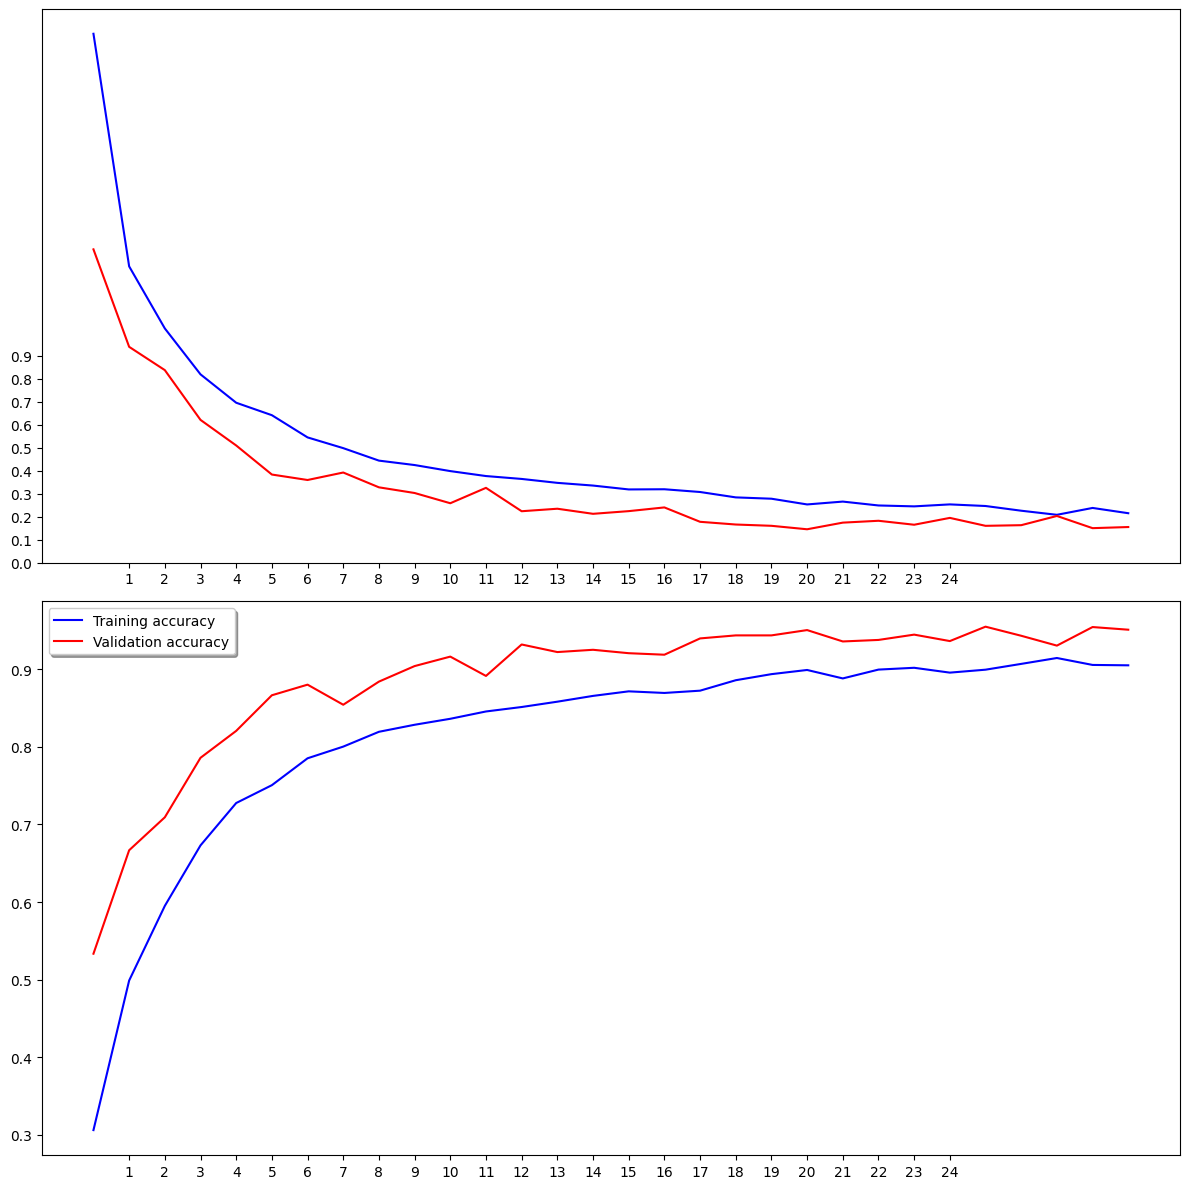

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
vgg16_fine_tuned.load_weights('drive/MyDrive/models/distracted_vgg16_best.hdf5')

In [ ]:
# evaluate_data = datagen.flow_from_directory(PREP_TEST_PATH,
#                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                         batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
ypred = vgg16_fine_tuned.predict(test_data)

evaluate_list = test_data.classes.tolist()

ypred_class = np.argmax(ypred,axis=1)
ytest = evaluate_list

54/54 [==============================] - 99s 2s/step


In [ ]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.946397
Precision: 0.947670
Recall: 0.946397
F1 score: 0.946421


In [ ]:
vgg16_fine_tuned.evaluate(test_data)

54/54 [==============================] - 77s 1s/step - loss: 0.1756 - accuracy: 0.9464


[0.17560885846614838, 0.9463971853256226]

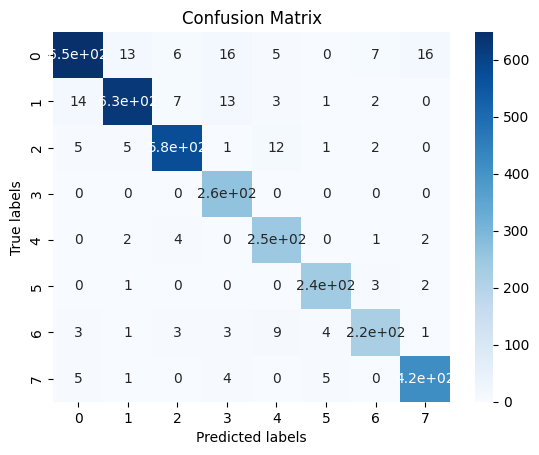

In [ ]:
cm = confusion_matrix(ytest, ypred_class)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels,predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [ ]:
class_names = list()
for name,idx in valid_data.class_indices.items():
    class_names.append(name)
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']


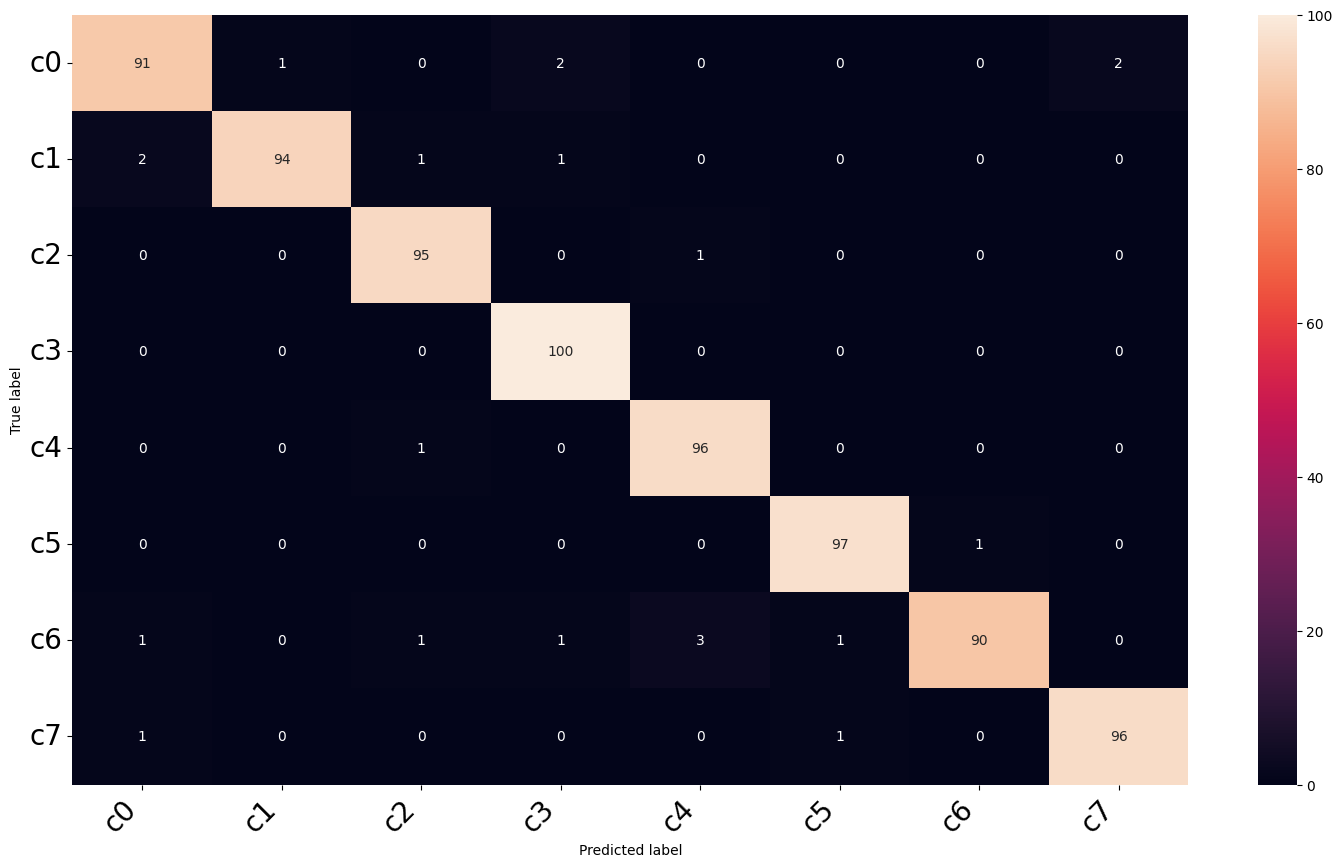

In [ ]:
print_heatmap(ytest,ypred,class_names)

1/1 [==============================] - 0s 22ms/step
8


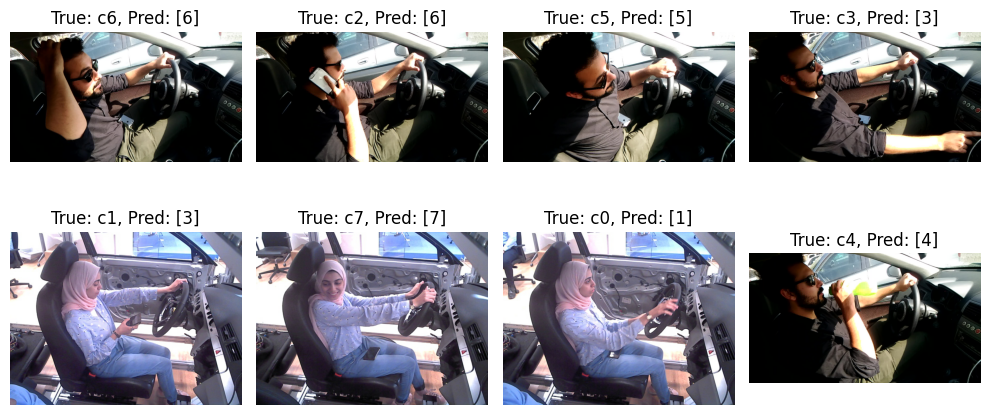

In [52]:
imgs = []
y_preds = []
y_trues = []
for i in range(9):
  cls = os.listdir(UNSEEN_PATH)[i]
  if cls != '.DS_Store':
    cls_path = os.path.join(UNSEEN_PATH, cls)
    img_name = os.listdir(cls_path)[27] 
    img_path = os.path.join(cls_path, img_name)
    img = Image.open(img_path)
    imgs.append(img)
    img_resize = img.resize((224, 224))
    img_array = np.array(img_resize)
    img_array = np.expand_dims(img_array, axis=0)
    input_data = preprocess_input(img_array)
    y_pred = vgg16_fine_tuned.predict(input_data)
    y_pred = np.argmax(y_pred, axis=1)
    y_preds.append(y_pred)
    y_trues.append(cls)
print(len(imgs))
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    # Plot the image
    img = imgs[i]
    ax.imshow(img)
    ax.axis('off')
    
    # Get the true and predicted labels
    true_label = y_trues[i]
    pred_label = y_preds[i]
    
    # Set the title of the plot with the true and predicted labels
    ax.set_title(f'True: {true_label}, Pred: {pred_label}')
    
    # Break out of the loop after 12 images have been plotted
    if i == 7:
        break

plt.tight_layout()
plt.show()